# 📦 YOLOv8 Invoice Detection — Roboflow → Train → Test


## 1) Скачайте Ultralytics (YOLOv8)

In [2]:
!pip -q install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 21.3/107.7 GB disk)


## 2) Создание рабочих папок

In [4]:
import os, shutil, zipfile
from pathlib import Path

WORKDIR = Path("/content")
DATA_DIR = WORKDIR / "dataset"
RUNS_DIR = WORKDIR / "runs"

DATA_DIR.mkdir(exist_ok=True)
print("✅ DATA_DIR:", DATA_DIR)

✅ DATA_DIR: /content/dataset


## 3) Получение датасета из Roboflow

### ✅ Загрузите `.zip` файл в  Colab
1. В Roboflow: **Download Dataset → YOLOv8 / Ultralytics → Download Zip**
2. Загрузите сюда (`Choose files`) — его нужно положить в `/content/`

In [6]:
from google.colab import files
uploaded = files.upload()  # выберите свой .zip архив

# find the uploaded zip file
zip_files = [f for f in uploaded.keys() if f.lower().endswith(".zip")]
assert zip_files, "❌ Нет загруженных .zip архивов. Пожалуйста загрузите свой датасет из Roboflow."
ZIP_PATH = WORKDIR / zip_files[0]
print("✅ Загружено в:", ZIP_PATH)

Saving My First Project.v2-first_batch.yolov8.zip to My First Project.v2-first_batch.yolov8 (1).zip
✅ Uploaded: /content/My First Project.v2-first_batch.yolov8 (1).zip


### Распакуйте dataset

In [7]:
# Если папка существует, удалите все из нее
if DATA_DIR.exists():
    shutil.rmtree(DATA_DIR)
DATA_DIR.mkdir(exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(DATA_DIR)

print("✅ Распаковано в:", DATA_DIR)

# show dataset structure
for p in sorted(DATA_DIR.glob("*")):
    print(" -", p.name)

✅ Unzipped to: /content/dataset
 - README.dataset.txt
 - README.roboflow.txt
 - data.yaml
 - test
 - train
 - valid


README.dataset.txt

📄 Это просто описание датасета

Обычно там написано:
- сколько классов
- названия классов
- как устроены папки
- иногда статистика

✅ На обучение не влияет

Это “инструкция” для человека.

README.roboflow.txt

📄 Это служебный файл Roboflow

Там часто есть:
- версия датасета
- параметры экспорта
- какие аугментации применялись (если были)
- иногда ссылка на проект

✅ На обучение тоже не влияет

Это “паспорт датасета” от Roboflow.

data.yaml ⭐ (самое важное!)

Это главный конфиг, по которому YOLO понимает:

- где лежат картинки для обучения
- где лежат картинки для проверки
- какие есть классы
- сколько классов

Примерно внутри будет что-то такое:
```python
train: train/images
val: valid/images

nc: 1 # То есть у нас всего 1 тип объекта, который мы детектируем.
names: ['invoice'] # Название класса №0
```
📌 YOLO будет читать этот файл и запускать обучение именно по нему.

Папки train, valid, test

Это три части датасета — YOLO использует их по-разному.

train/ — обучение

Это главная папка для обучения модели

Там есть две внутренние папки:

- train/images/ — картинки
- train/labels/ — разметка (txt файлы)

valid/ — проверка качества во время обучения

Это валидация

На ней модель не учится, она проверяется

Там тоже:
- valid/images/
- valid/labels/

📌 Почему нужно?

Чтобы YOLO после каждой эпохи говорил:
- “Я стал лучше или хуже?”
- “У меня растёт точность или я переобучился?”

test/ — финальный тест (иногда не используется)

Это отдельный набор, чтобы проверить модель после обучения.

Тоже:

- test/images/
- test/labels/

📌 Важно:
YOLO обычно автоматически обучается на train и проверяется на valid

test — часто оставляют “на потом”, как экзамен.

## 4) Разместите `data.yaml`

YOLO для тренировки нужен конфиг файл:
- `data.yaml` (or `dataset.yaml`)
- он содержит пути к train/val фотографиям и названия классов


In [8]:
# Поиск YAML файла
yaml_files = list(DATA_DIR.rglob("*.yaml"))
print("YAML файл был найден:", [str(p) for p in yaml_files])

# Выбор первого yaml автоматически
assert yaml_files, "❌ .yaml не был найден. Убедитесь, что Вы используете верный формат загрузки (Yolo8/Ultralytics)."
DATA_YAML = yaml_files[0]
print("✅ Using:", DATA_YAML)

YAML files found: ['/content/dataset/data.yaml']
✅ Using: /content/dataset/data.yaml


### Превью `data.yaml`

In [9]:
print(DATA_YAML.read_text()[:2000])

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['invoice']

roboflow:
  workspace: itstep
  project: my-first-project-dtyj6
  version: 2
  license: CC BY 4.0
  url: https://universe.roboflow.com/itstep/my-first-project-dtyj6/dataset/2


## 5) Исправление путей в датасете (частая проблема Roboflow)

Иногда `data.yaml` содержит **относительные пути**, которые не совпадают с реальным расположением папок.  
Мы автоматически определим корректные пути для `train` и `val` папок с фотографмиями и обновим `data.yaml`.


In [12]:
import yaml

def find_images_dir(root: Path, key: str):
    candidates = []
    for p in root.rglob("images"):
        parent = p.parent.name.lower()
        if key in parent:
            candidates.append(p)
    if candidates:
        return candidates[0]
    all_images = list(root.rglob("images"))
    return all_images[0] if all_images else None

train_images = find_images_dir(DATA_DIR, "train")
val_images = find_images_dir(DATA_DIR, "val") or find_images_dir(DATA_DIR, "valid")

print("Detected train images:", train_images)
print("Detected val images:", val_images)

assert train_images and val_images, "❌ Could not detect train/val images folders."

cfg = yaml.safe_load(DATA_YAML.read_text())

cfg["path"] = str(DATA_DIR)
cfg["train"] = str(train_images.relative_to(DATA_DIR))
cfg["val"] = str(val_images.relative_to(DATA_DIR))

patched_yaml = DATA_DIR / "data_patched.yaml"
patched_yaml.write_text(yaml.safe_dump(cfg, sort_keys=False))
print("✅ Patched YAML saved to:", patched_yaml)
print(patched_yaml.read_text())

Detected train images: /content/dataset/train/images
Detected val images: /content/dataset/valid/images
✅ Patched YAML saved to: /content/dataset/data_patched.yaml
train: train/images
val: valid/images
test: ../test/images
nc: 1
names:
- invoice
roboflow:
  workspace: itstep
  project: my-first-project-dtyj6
  version: 2
  license: CC BY 4.0
  url: https://universe.roboflow.com/itstep/my-first-project-dtyj6/dataset/2
path: /content/dataset



## 6) Быстрая проверка работоспособности набора данных (фото + метки)

Мы проверяем:
- количество изображений в train/val
- количество файлов меток (`.txt`)


In [17]:
def count_files(folder: Path, pattern: str):
    return len(list(folder.rglob(pattern)))

train_img_count = count_files(train_images, "*.jpg") + count_files(train_images, "*.png") + count_files(train_images, "*.jpeg")
val_img_count = count_files(val_images, "*.jpg") + count_files(val_images, "*.png") + count_files(val_images, "*.jpeg")

train_lbl_dir = train_images.parent / "labels"
val_lbl_dir = val_images.parent / "labels"

train_lbl_count = count_files(train_lbl_dir, "*.txt") if train_lbl_dir.exists() else 0
val_lbl_count = count_files(val_lbl_dir, "*.txt") if val_lbl_dir.exists() else 0

print("📸 Train images:", train_img_count)
print("🏷️ Train labels:", train_lbl_count)
print("📸 Val images:", val_img_count)
print("🏷️ Val labels:", val_lbl_count)

assert train_img_count > 0 and val_img_count > 0, "❌ No images found. Check dataset export."
assert train_lbl_count > 0, "❌ No train labels found. Check labeling/export."

📸 Train images: 22
🏷️ Train labels: 22
📸 Val images: 7
🏷️ Val labels: 7


## 7) Выберите размер модели (в зависимости от вашего компьютера / графического процессора)

✅ Рекомендуется:
- **YOLOv8n (nano)** — быстрый, легкий, подходит для слабого оборудования
- **YOLOv8s (маленький)** — более точен, требует большего количества графического процессора

Вы можете начать с `yolov8n.pt` и позже его заменить.


In [15]:
MODEL_NAME = "yolov8n.pt"  # измените модель на "yolov8s.pt" или "yolov8m.pt" если позволяет GPU
IMG_SIZE = 640                 # если ошибка out-of-memory, уменьшите размер изображения до 512 или 416
EPOCHS = 60                    # class-friendly value
BATCH = 16                     # если ошибка out-of-memory, уменьшите до 8 или 4

print("✅ Model:", MODEL_NAME)
print("✅ imgsz:", IMG_SIZE, "| epochs:", EPOCHS, "| batch:", BATCH)

✅ Model: yolov8n.pt
✅ imgsz: 640 | epochs: 60 | batch: 16


## 8) Тренировка YOLO на накладных

Эта команда создаст папку:
`runs/detect/invoice_train/`

и сохранит:
- `best.pt`
- графики метрик


In [16]:
!yolo detect train data="{patched_yaml}" model="{MODEL_NAME}" imgsz={IMG_SIZE} epochs={EPOCHS} batch={BATCH} name="invoice_train"

Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data_patched.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=invoice_train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.

```bash
yolo detect train data="C:\path\to\data.yaml" model="yolov8n.pt" imgsz=640 epochs=60 batch=16 name="invoice_train"
```

## 9) Просмотр результатов обучения

In [19]:
from pathlib import Path
result_dir = Path("runs/detect/invoice_train")
print("✅ Result dir:", result_dir)

# Список файлов
for p in sorted(result_dir.glob("*")):
    print(" -", p.name)

✅ Result dir: runs/detect/invoice_train
 - BoxF1_curve.png
 - BoxPR_curve.png
 - BoxP_curve.png
 - BoxR_curve.png
 - args.yaml
 - confusion_matrix.png
 - confusion_matrix_normalized.png
 - labels.jpg
 - results.csv
 - results.png
 - train_batch0.jpg
 - train_batch1.jpg
 - train_batch100.jpg
 - train_batch101.jpg
 - train_batch102.jpg
 - train_batch2.jpg
 - val_batch0_labels.jpg
 - val_batch0_pred.jpg
 - weights


### Показать основные графики (если таковые имеются)

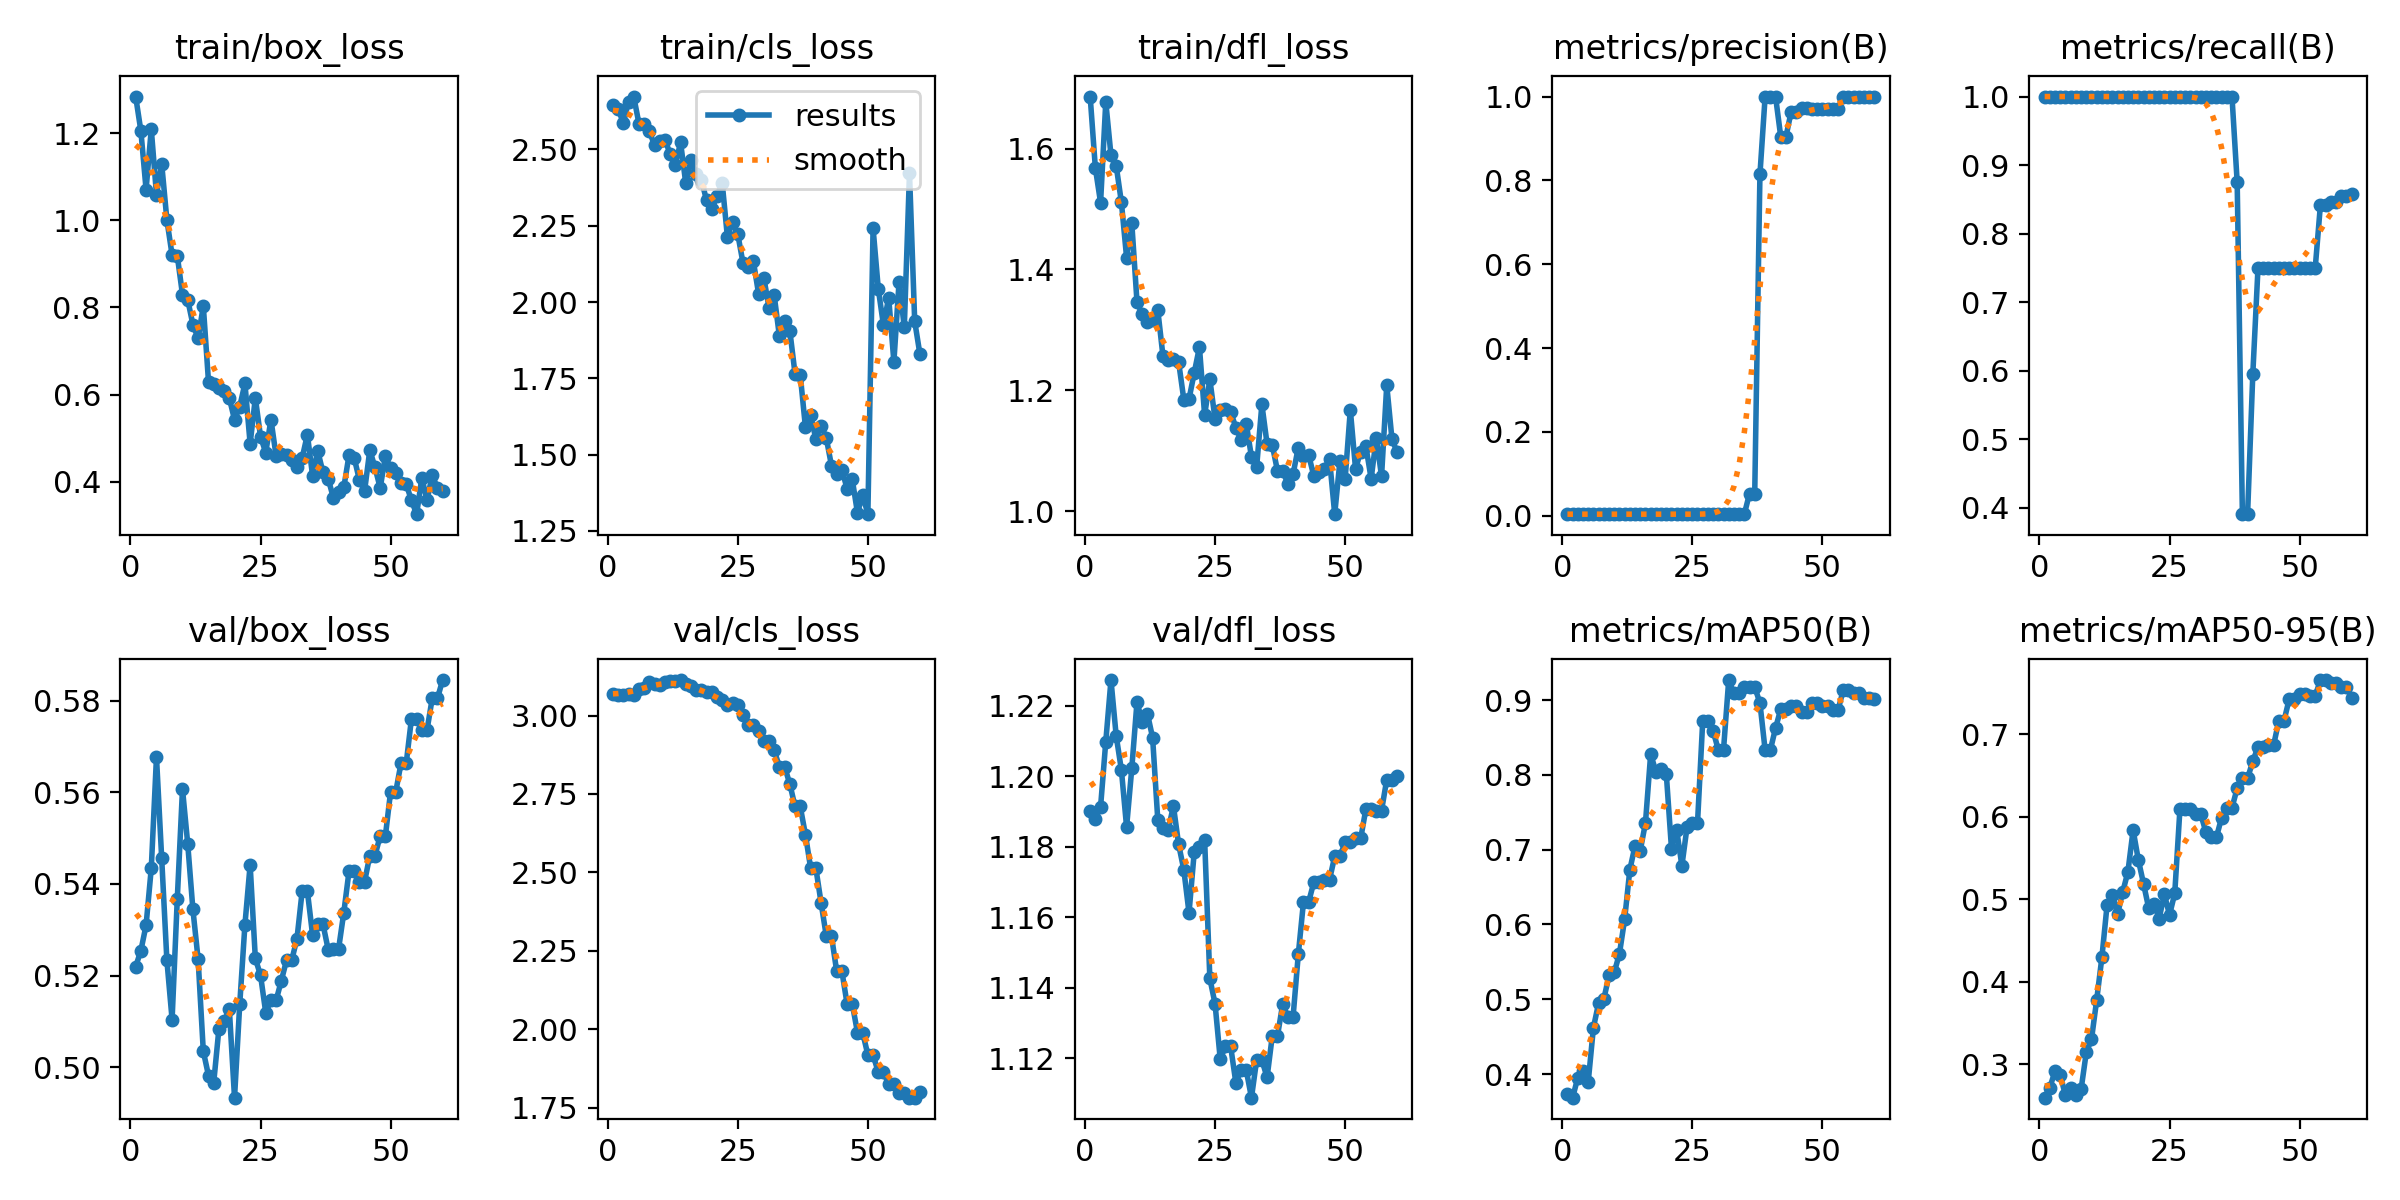

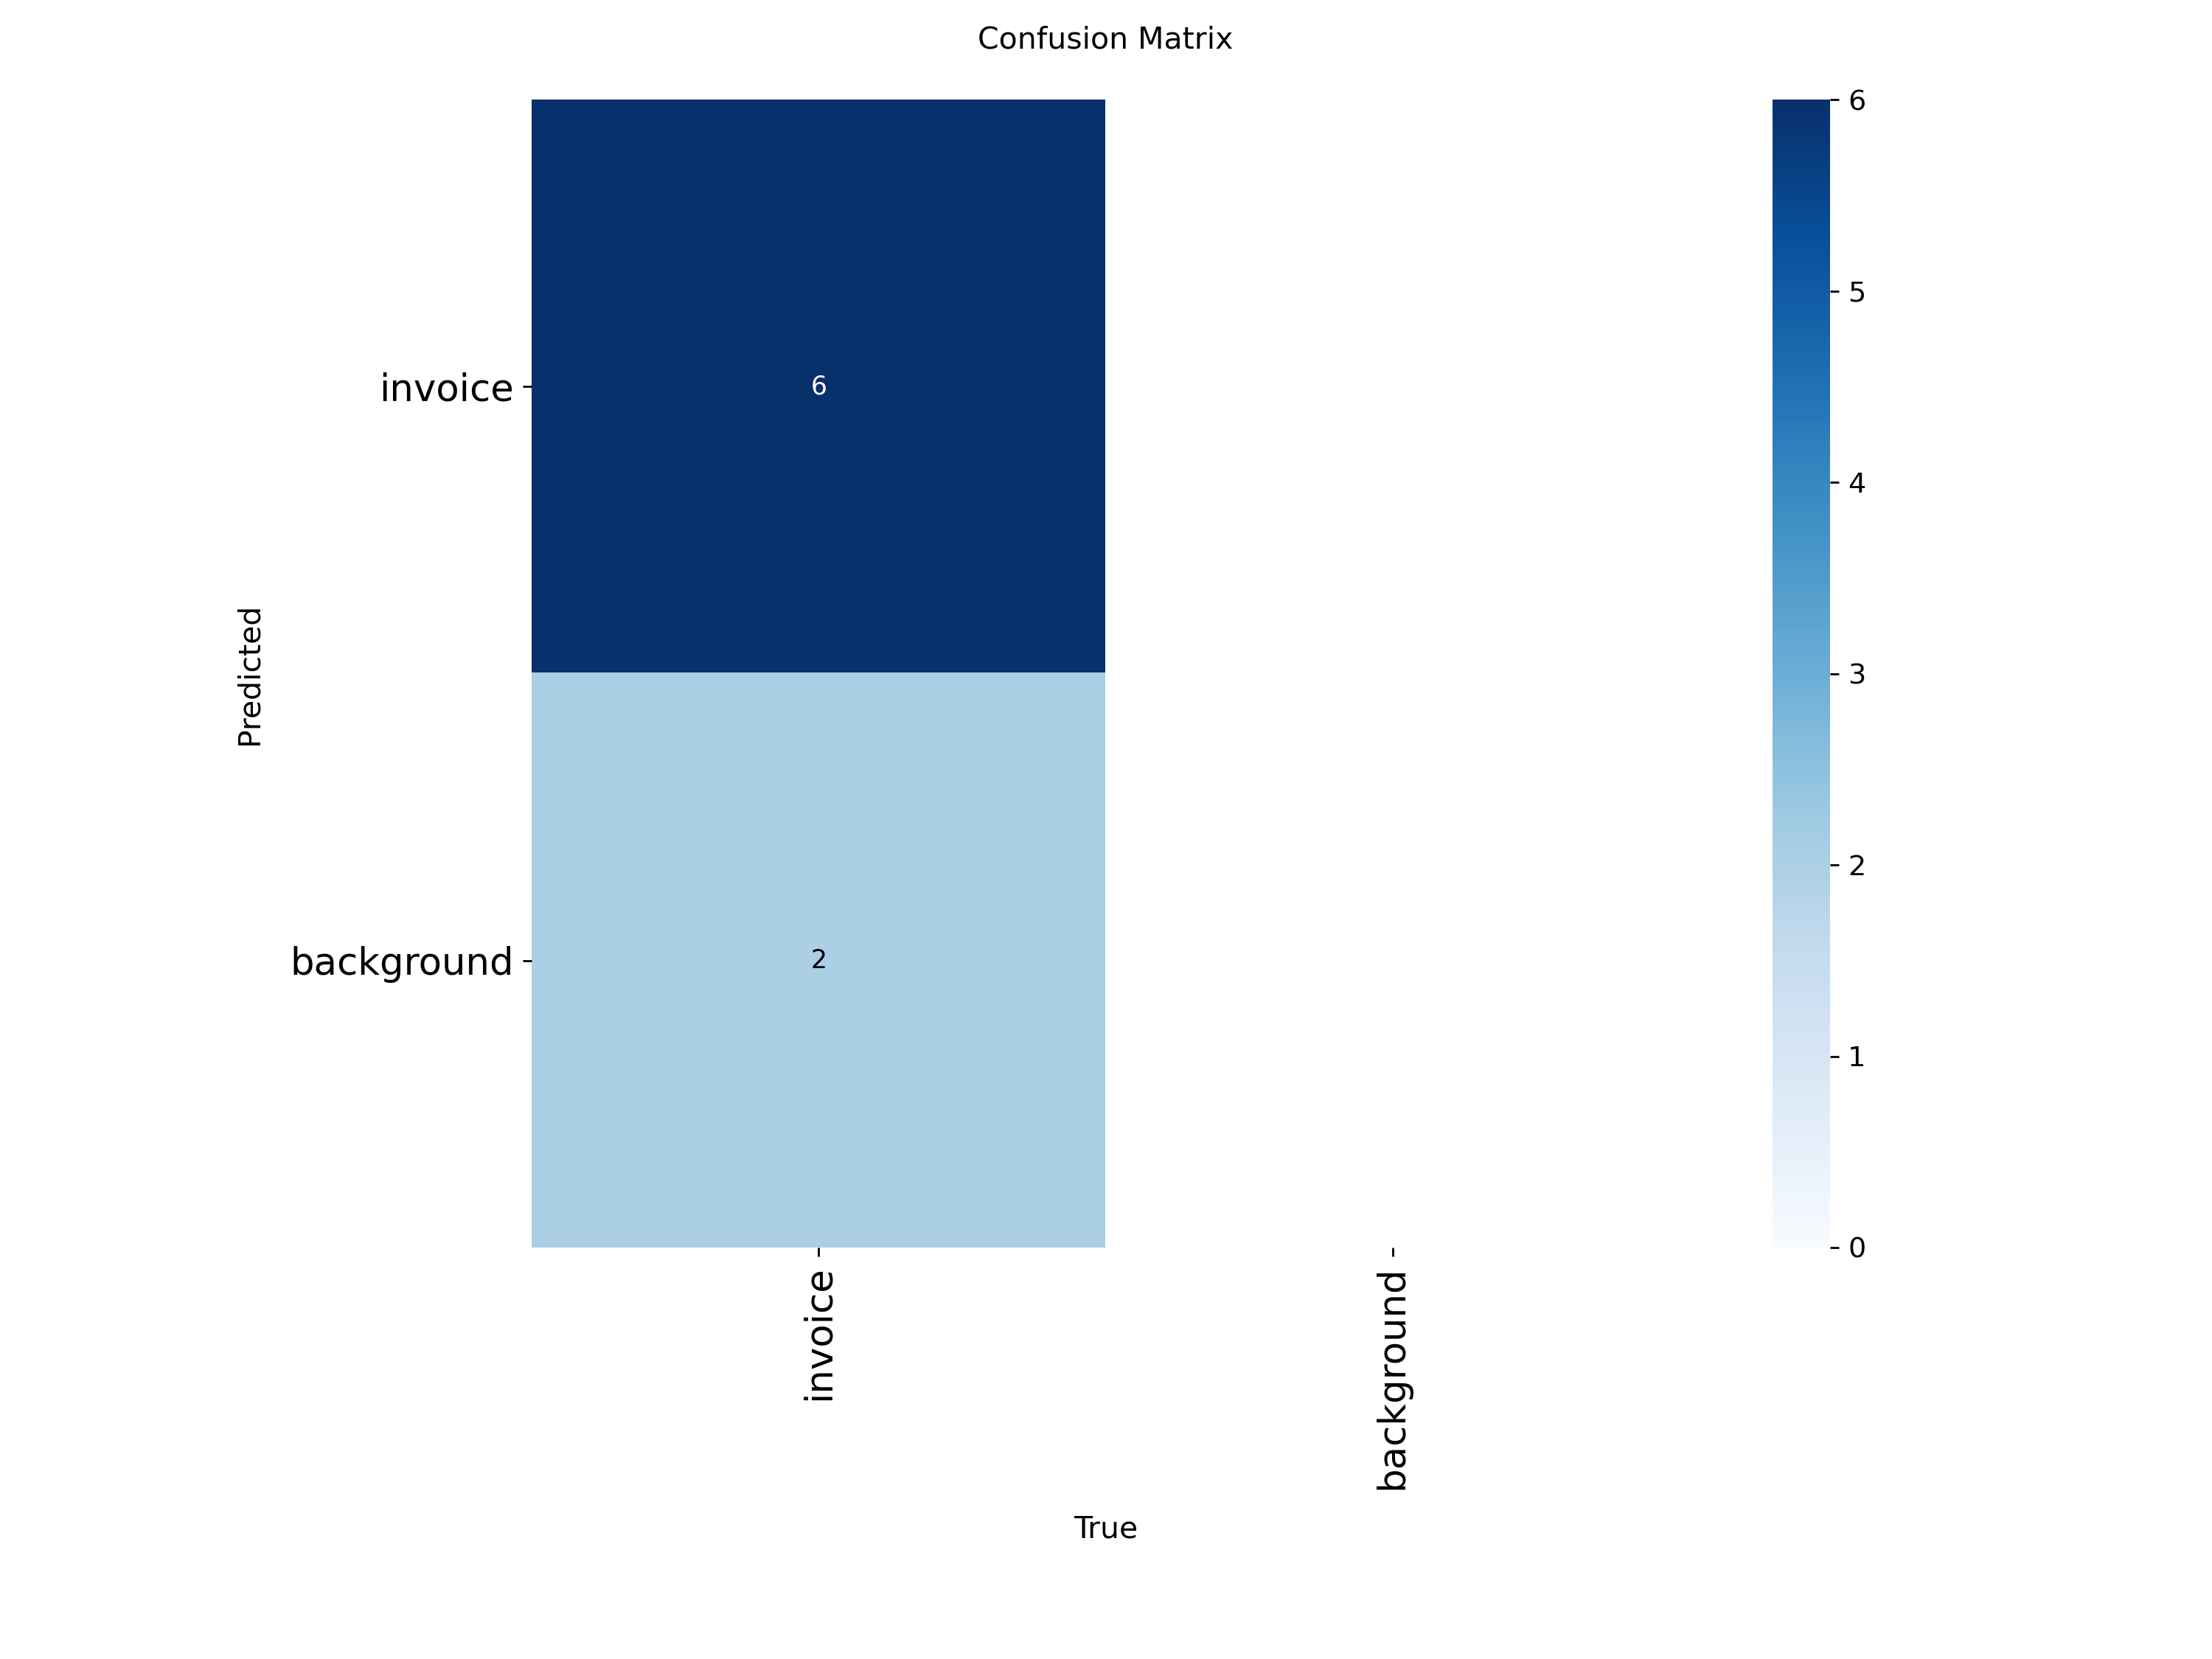

In [20]:
from IPython.display import Image, display

plots = [
    "results.png",
    "confusion_matrix.png",
    "PR_curve.png",
    "F1_curve.png",
    "P_curve.png",
    "R_curve.png",
]
for f in plots:
    p = result_dir / f
    if p.exists():
        display(Image(filename=str(p), width=900))

## 10) Вывод (протестируйте свою модель на новых фотографиях)

### ✅ Вариант А: Загрузите тестовые изображения
Загрузите любые фотографии накладных и запустите обнаружение.

Прогнозы появятся в разделе:
`runs/detect/predict/`


In [22]:
from pathlib import Path

TEST_DIR = Path("/content/dataset/test/images")

test_imgs = sorted([str(p) for p in TEST_DIR.glob("*") if p.suffix.lower() in [".jpg", ".jpeg", ".png"]])

print("✅ Found test images:", len(test_imgs))
print(test_imgs[:5])

✅ Found test images: 3
['/content/dataset/test/images/0000001423388_webp.rf.77ed34c3628c74091c3ab7b60d0c4d2b.jpg', '/content/dataset/test/images/0000002252034_webp.rf.213c56d1e5b8b9ea87db119506117772.jpg', '/content/dataset/test/images/0000002252185_webp.rf.ac48b998045107f8b87d3f6265871f61.jpg']


In [24]:
BEST_MODEL = "runs/detect/invoice_train/weights/best.pt"
!yolo detect predict model="{BEST_MODEL}" source="{TEST_DIR}" conf=0.25 save=True
print("✅ Done. Check runs/detect/predict/")

Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cpu CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 73 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

image 1/3 /content/dataset/test/images/0000001423388_webp.rf.77ed34c3628c74091c3ab7b60d0c4d2b.jpg: 480x640 1 invoice, 230.2ms
image 2/3 /content/dataset/test/images/0000002252034_webp.rf.213c56d1e5b8b9ea87db119506117772.jpg: 640x512 1 invoice, 225.0ms
image 3/3 /content/dataset/test/images/0000002252185_webp.rf.ac48b998045107f8b87d3f6265871f61.jpg: 480x640 1 invoice, 180.2ms
Speed: 4.5ms preprocess, 211.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)
Results saved to /content/runs/detect/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict
✅ Done. Check runs/detect/predict/


### Просмотр результата прогнозирования

Predicted images: ['0000001423388_webp.rf.77ed34c3628c74091c3ab7b60d0c4d2b.jpg']


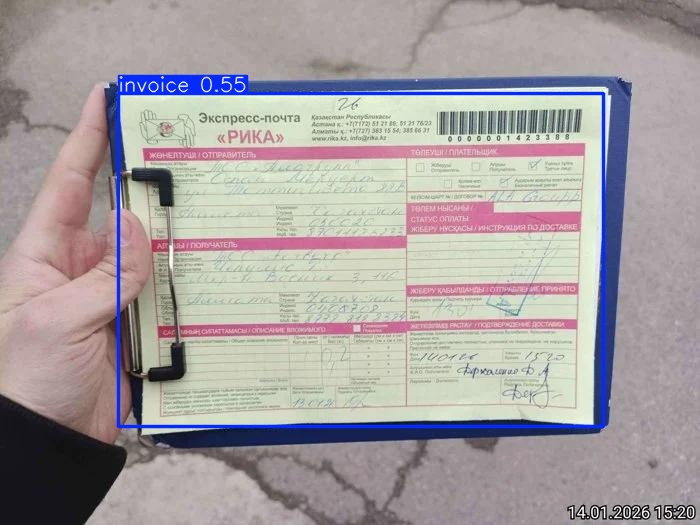

In [26]:
pred_dir = Path("runs/detect/predict")
pred_images = list(pred_dir.glob("*.jpg")) + list(pred_dir.glob("*.png"))
print("Predicted images:", [p.name for p in pred_images])

if pred_images:
    display(Image(filename=str(pred_images[0]), width=900))

## 11) Экспортировать `best.pt` (загрузить обученную модель)

Вы можете скачать тренировочные веса и использовать их позже на своем компьютере.


In [25]:
from google.colab import files
files.download(BEST_MODEL)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 12) (Необязательно) Сохраните на Google Диске

Если вы хотите сохранить результаты между сеансами, подключите диск и скопируйте папку.

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
# Измените пути, если нужно
DEST = Path("/content/drive/MyDrive/yolo_invoice_project")
DEST.mkdir(parents=True, exist_ok=True)

# Скопируйте всю папку
shutil.copytree(result_dir, DEST / "invoice_train", dirs_exist_ok=True)
print("✅ Saved to:", DEST / "invoice_train")

✅ Saved to: /content/drive/MyDrive/yolo_invoice_project/invoice_train


# 🧯 Устранение неполадок (наиболее распространенные проблемы)

### ❌ CUDA out of memory
✅ Решение:
- уменьшить `BATCH`: 16 → 8 → 4  
- уменьшить `IMG_SIZE`: 640 → 512 → 416

### ❌ Model doesn’t detect anything
✅ Решение:
- уменьшить confidence: `conf=0.10`
- проверить качество меток (boxes)
- добавить больше фотографий, сбалансировать классы

### ❌ No labels found
✅ Решение:
- убедитесь, что скачанный датасет был в YOLO формате
- проверьте папки: `train/labels` и `valid/labels`
